## EEG CNN with Multiheaded Attention

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from nndl.architectures import DeepConvNet, DeepConvLSTM, DeepConvTransformer

torch.cuda.empty_cache()
print(f'Using pytorch version {torch.__version__}')

Using pytorch version 1.13.1


In [2]:
# %% Data Loading #####
my_path = r'/home/abrahamcanafe/PythonProjects/ECE247C/Final_Project/project_data/project/'

X_test = np.load(my_path + 'X_test.npy')
y_test = np.load(my_path + 'y_test.npy')
person_train_valid = np.load(my_path + 'person_train_valid.npy')
X_train_valid = np.load(my_path + 'X_train_valid.npy')
y_train_valid = np.load(my_path + 'y_train_valid.npy')
y_train_valid = (y_train_valid - np.min(y_train_valid)).astype('int')
person_test = np.load(my_path + 'person_test.npy')

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [3]:
# %% Check for cuda
print(torch.cuda.is_available())
device_id = 0 if torch.cuda.is_available() else 'cpu'
device = torch.device(device_id)

True


In [4]:
# %% ######### Data preparation with Gaussian Noise (credit to Tonmoy)
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:1000] # 500
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


In [5]:
# %% ###### Create dataset and DataLoader ######
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        if isinstance(X, np.ndarray):
            self.X = torch.FloatTensor(X)
        else:
            self.X = X
        if isinstance(Y, np.ndarray):
            self.Y = torch.LongTensor(Y)
        else:
            self.Y = Y
        return
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [6]:
# Select batch size
batch_size = 64

In [7]:
### Transform data using techniques from Tonmoy's notebook
X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_valid_prep,y_train_valid_prep, test_size=0.2, random_state=42) 
X_test_np,y_test_np = data_prep(X_test,y_test,2,2,True)

n_train_instances, n_eeg_channels, n_time_steps = X_train_np.shape

Shape of X after trimming: (2115, 22, 1000)
Shape of X after maxpooling: (2115, 22, 500)
Shape of X after averaging+noise and concatenating: (4230, 22, 500)
Shape of X after subsampling and concatenating: (8460, 22, 500)
Shape of X after trimming: (443, 22, 1000)
Shape of X after maxpooling: (443, 22, 500)
Shape of X after averaging+noise and concatenating: (886, 22, 500)
Shape of X after subsampling and concatenating: (1772, 22, 500)


In [8]:
### Create torch tensors for training/validation/testing
X_train = torch.FloatTensor(X_train_np).to(device)
X_val = torch.FloatTensor(X_val_np).to(device)
y_train = torch.LongTensor(y_train_np).to(device)
y_val = torch.LongTensor(y_val_np).to(device)

X_test = torch.FloatTensor(X_test_np).to(device)
y_test = torch.LongTensor(y_test_np).to(device)

train_dataset = CreateDataset(X_train, y_train) #### fix this later
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = CreateDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False) 

In [9]:
# %% ##########
import tqdm
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

#model = DeepConvNet().to(device)
#model = DeepConvLSTM().to(device)
model = DeepConvTransformer(input_shape=(22,n_time_steps), n_input_channels = 22, n_spatial_filters=50, n_classes=4).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay=0.01) # 0.01 for MHA, 0.001 otherwise?
celoss = nn.CrossEntropyLoss() # lr = 0.0005

loss_hist = []
val_loss_hist = []
acc_hist = []
val_acc_hist = []

num_epochs = 50
pbar = tqdm.tqdm(range(num_epochs), position=0, leave=True,
                 bar_format = '{l_bar}{bar: 30}{r_bar}')


for epoch in pbar:
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        out = model(x)
        loss = celoss(out, y)
        
        loss.backward()
        optimizer.step()
        
        loss_hist.append(loss.item())
        
        
    model.eval()
    n_samples = 0
    n_correct = 0
    with torch.no_grad():
        for batch in train_dataloader:
            x, y = batch
            out = model(x)
            n_samples += len(y)
            n_correct += (out.max(1)[1] == y).detach().cpu().numpy().sum()
            
    acc_hist.append(n_correct / n_samples)    
        
    n_samples = 0
    n_correct = 0
    with torch.no_grad():
        for batch in val_dataloader:
            x, y = batch
            out = model(x)
            loss = celoss(out,y)
            val_loss_hist.append(loss.item())
            n_samples += len(y)
            n_correct += (out.max(1)[1] == y).detach().cpu().numpy().sum()
            
    val_acc_hist.append(n_correct / n_samples)
    
    
    pbar.set_postfix({'acc': acc_hist[-1], 'val_acc': val_acc_hist[-1]})

/home/abrahamcanafe/anaconda3/envs/jupyter-env/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████████████████████████| 50/50 [00:45<00:00,  1.10it/s, acc=0.95, val_acc=0.907] 


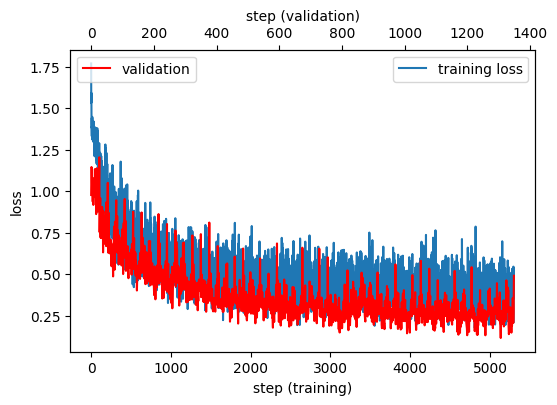

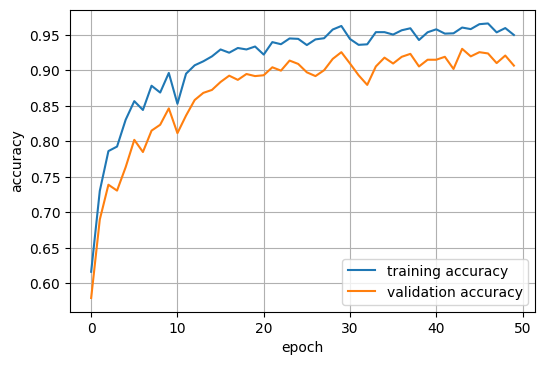

In [10]:
# %% ##########
plt.figure(dpi=100)
plt.plot(loss_hist, label='training loss')
#plt.yscale('log')
plt.ylabel('loss')
plt.legend() #loc='lower left')
plt.xlabel('step (training)')
plt.twiny()
plt.plot(val_loss_hist, 'r', label='validation')
plt.xlabel('step (validation)')
plt.legend(loc='upper left')
#plt.legend(['training loss','validation loss'])


plt.figure(dpi=100)
plt.plot(acc_hist)
plt.plot(val_acc_hist)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.grid()


In [11]:
# %% ########### Saving model parameters
from sklearn.metrics import accuracy_score
y_test_pred = np.argmax(model(X_test).cpu().detach().numpy(),axis=1)
y_true = y_test.cpu().detach().numpy()
y_true = y_true - y_true.min()

acc = accuracy_score(y_true, y_test_pred)

print('Test Accuracy of CNN Model: ', acc)

Test Accuracy of CNN Model:  0.7059819413092551


#### Score report and confusion matrix

In [12]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_test_pred, average='macro')
print('Precision: ', precision)
print('Recall: ', recall)
print('F1_score: ', f1_score)

Precision:  0.7054860999684105
Recall:  0.7033104001465437
F1_score:  0.7041859211414487


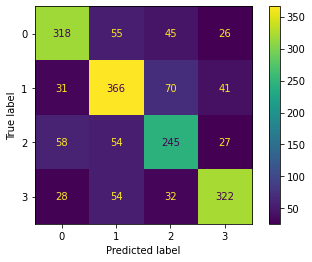

In [13]:
cm = confusion_matrix(y_true, y_test_pred)
class_names = {0:'Cue onset left', 1: 'Cue onset right', 2: 'Cue onset foot', 3: 'Cue onset tongue'}

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()